# Data analysis

Experiment information:
- One million function evaluations
- **sade_remc**: is the best method from HM, but with more evals
- **sade_mc_final**: is sade + MC + ffi9 + rmsd crowding + spicker + hooke jeeves on cluster centroids
- **sade_remc_final**: is the same as above, but REMC instead of MC
- **sade_mc_ffi9_02**: is HM method + forced fragment insertion of size 2 with 0.02 chance of happening per individal per generation
- **sade_remc_ffi9_02**: same as above but with REMC instead of MC

In [1]:
import datetime
import string
import random
import pickle
import time
import sys
import os
import re

import data_utils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid");

In [2]:
root_path = '/home/h3nnn4n/progs/de_supimpa/tools/notebooks/analysis'
base_path = '/home/h3nnn4n/progs/de_supimpa/src'


def reset_path():
    os.chdir(base_path)
    
def reset_to_root_path():
    os.chdir(root_path)

    
reset_to_root_path()
reset_path()

In [3]:
runs = [
    'de_experiment_final',
    'de_sade_remc',
    'de_rosetta',
    'de_ffi',
    'de_experiment_final_8_prot',
    'de_final_1rop_1wqc_1lwy',
    'de_rosetta_all_prots',
    'de_other_experiments_all_prots',
]

In [4]:
protein_blacklist = ['1ab1', '1dfn', '2P5K', '2pmr', '3V1A']

dataset = data_utils.load_all_data(runs)
alldata = data_utils.merge_data(dataset, protein_blacklist=protein_blacklist)


def filter_methods(data, allowed=[]):
    proteins = sorted(list(data.keys()))
    
    for protein in proteins:
        methods = sorted(list(data[protein].keys()))
        
        for method in methods:
            if method not in allowed:
                data[protein].pop(method)
        
    return data


def rename_methods(data, renamer={}):
    proteins = sorted(list(data.keys()))

    for protein in proteins:
        methods = sorted(list(data[protein].keys()))
        
        for method in methods:
            if method in renamer.keys():
                tmp = data[protein].pop(method)
                data[protein][renamer[method]] = tmp


filter_methods(alldata, allowed=['classic-abinitio', 'sade_remc_final', 'sade_mc_final', 'sade_remc'])
rename_methods(alldata, renamer={'sade_remc_final': 'ppf-remc', 'sade_mc_final': 'ppf-mc', 'sade_remc': 'sade-remc'})
print('Finished')

INFO: Loaded 8 experiment runs dataset
removed 5 proteins. Blacklist had 5
[WARN] removing sade_de_mc from 1rop
[WARN] removing sade_de_remc from 1rop
[WARN] removing sade_mc from 1rop
[WARN] removing sade_de_mc from 1utg
[WARN] removing sade_de_remc from 1utg
[WARN] removing sade_mc from 1utg
[WARN] removing sade_de_mc from 1wqc
[WARN] removing sade_de_remc from 1wqc
[WARN] removing sade_mc from 1wqc
[WARN] removing sade_de_mc from 1acw
[WARN] removing sade_de_remc from 1acw
[WARN] removing sade_mc from 1acw
[WARN] removing sade_de_mc from 2mr9
[WARN] removing sade_de_remc from 2mr9
[WARN] removing sade_mc from 2mr9
[WARN] removing sade_de_mc from 1l2y
[WARN] removing sade_de_remc from 1l2y
[WARN] removing sade_mc from 1l2y
Finished


# Pareto

In [5]:
def summary_to_dataframe(summary, columns=['min', 'max', 'mean', 'std', 'median'], rename=None):
    proteins = sorted(list(summary.keys()))
    methods = sorted(list(summary[proteins[0]].keys()))
    base_columns = ['protein', 'experiment']
    
    d = {}
    for column in columns + base_columns:
        d[column] = []
    
    for protein in proteins:
        for method in methods:
            d['protein'].append(protein)
            
            if rename is not None and method in rename.keys():
                d['experiment'].append(rename[method])
            else:
                d['experiment'].append(method)
            
            for column in columns:
                d[column].append(summary[protein][method]['data'][column])
                                
    return pd.DataFrame(data=d)

In [33]:
def is_pareto_front(df, row, xlabel, ylabel):
    x = row[xlabel]
    y = row[ylabel]
    
    is_min_x = df.loc[df[ylabel] == y].min()[xlabel] <= x
    is_min_y = df.loc[df[xlabel] == x].min()[ylabel] <= y
    
    is_double = len(df.loc[(df[xlabel] < x) & (df[ylabel] < y)]) == 0
    
    return is_min_x and is_min_y and is_double


def pareto(protein, mode='best_by_rmsd', metric='min'):
    summary_rmsd = data_utils.experiment_summary(alldata, mode=mode, metric='rmsd_before')
    df_rmsd = summary_to_dataframe(summary_rmsd)

    summary_energy = data_utils.experiment_summary(alldata, mode=mode, metric='scorefxn')
    df_energy = summary_to_dataframe(summary_energy)

    df_rmsd = df_rmsd[df_rmsd.protein == protein]
    df_energy = df_energy[df_energy.protein == protein]
    
    df = pd.DataFrame(
        [df_rmsd[metric], df_energy[metric], df_rmsd['experiment']],
        index=['rmsd', 'energy', 'experiment']
    ).transpose()
    
    is_pareto = df.apply(lambda row: is_pareto_front(df, row, 'rmsd', 'energy'), axis=1)
    df_pareto = df.loc[is_pareto].sort_values(by=['rmsd'])

    sns.set(rc={'figure.figsize':(16, 10)})
    
    plot = sns.scatterplot(x='rmsd', y='energy', hue='experiment', style='experiment', data=df, s=250)
    plt.plot(df_pareto['rmsd'], df_pareto['energy'], '--', label='Pareto frontier', alpha=0.5)
    
    plot.set_title('Pareto for %s using %s' % (protein, metric), fontsize=50)
    plot.set_ylabel('Energy (Lower is better)', fontsize=32)
    plot.set_xlabel('RMSD (Lower is better)', fontsize=32)
    plot.tick_params(labelsize=25)

    plt.setp(plot.get_legend().get_texts(), fontsize='32')
    plt.setp(plot.get_legend().get_title(), fontsize='32')
    
    for lh in plot.get_legend().legendHandles: 
        lh._sizes = [150] 

#     plot.get_legend().set_title('Methods')

    name = '%s_%s_%s.pdf' % (
        protein,
        mode,
        metric
    )
    
    print(name)
    
    plot.get_figure().savefig(name)

    return plot

1acw_best_by_rmsd_min.pdf


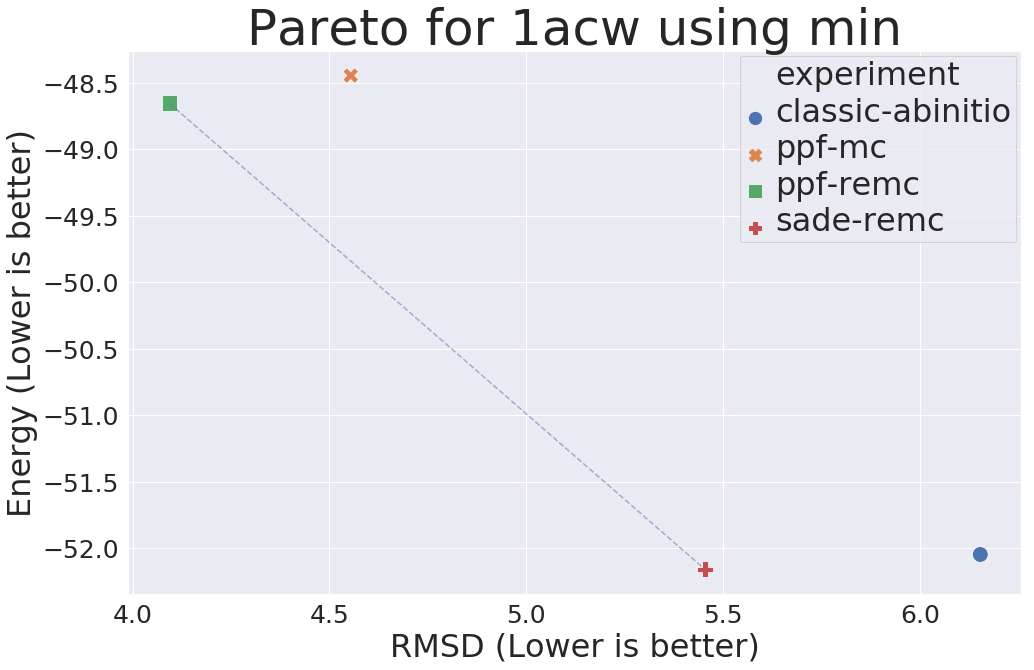

In [34]:
pareto('1acw')

In [35]:
for protein in alldata.keys():
    pareto(protein=protein, mode='best_by_rmsd', metric='min').clear();
    pareto(protein=protein, mode='best_by_energy', metric='min').clear();

plt.clf()

1rop_best_by_rmsd_min.pdf
1rop_best_by_energy_min.pdf
1utg_best_by_rmsd_min.pdf
1utg_best_by_energy_min.pdf
1ail_best_by_rmsd_min.pdf
1ail_best_by_energy_min.pdf
1zdd_best_by_rmsd_min.pdf
1zdd_best_by_energy_min.pdf
1wqc_best_by_rmsd_min.pdf
1wqc_best_by_energy_min.pdf
1crn_best_by_rmsd_min.pdf
1crn_best_by_energy_min.pdf
1acw_best_by_rmsd_min.pdf
1acw_best_by_energy_min.pdf
2mr9_best_by_rmsd_min.pdf
2mr9_best_by_energy_min.pdf
1enh_best_by_rmsd_min.pdf
1enh_best_by_energy_min.pdf
1l2y_best_by_rmsd_min.pdf
1l2y_best_by_energy_min.pdf


# Pareto with best by rmsd and best by energy

In [11]:
def get_best_by_rmsd_data(protein, metric):
    mode='best_by_rmsd'
    
    rename = {'ppf-remc': 'ppf-remc best by rmsd', 'ppf-mc': 'ppf-mc best by rmsd'}
    summary_rmsd = data_utils.experiment_summary(alldata, mode=mode, metric='rmsd_before')
    df_rmsd = summary_to_dataframe(summary_rmsd, rename=rename)

    summary_energy = data_utils.experiment_summary(alldata, mode=mode, metric='scorefxn')
    df_energy = summary_to_dataframe(summary_energy, rename=rename)

    df_rmsd = df_rmsd[df_rmsd.protein == protein]
    df_energy = df_energy[df_energy.protein == protein]
    
    return df_rmsd, df_energy
    
    
def get_best_by_energy_data(protein, metric):
    mode='best_by_energy'
    
    gambi = {protein: alldata[protein]}
    
    rename = {'ppf-remc': 'ppf-remc best by energy', 'ppf-mc': 'ppf-mc best by energy'}
    summary_rmsd = data_utils.experiment_summary(gambi, mode=mode, metric='rmsd_before')
    df_rmsd = summary_to_dataframe(summary_rmsd, rename=rename)

    summary_energy = data_utils.experiment_summary(gambi, mode=mode, metric='scorefxn')
    df_energy = summary_to_dataframe(summary_energy, rename=rename)

    df_rmsd = df_rmsd[df_rmsd.protein == protein]
    df_energy = df_energy[df_energy.protein == protein]
    
    return df_rmsd, df_energy

def get_base_data(protein, metric):    
    df_rmsd_a, df_energy_a = get_best_by_rmsd_data(protein, metric)
    df_rmsd_b, df_energy_b = get_best_by_energy_data(protein, metric)
        
    df_rmsd = df_rmsd_a\
      .append(df_rmsd_b.loc[df_rmsd_b.loc[:, 'experiment'] == 'ppf-remc best by energy', :])\
      .append(df_rmsd_b.loc[df_rmsd_b.loc[:, 'experiment'] == 'ppf-mc best by energy', :])
    
    df_energy = df_energy_a\
      .append(df_energy_b.loc[df_energy_b.loc[:, 'experiment'] == 'ppf-remc best by energy', :])\
      .append(df_energy_b.loc[df_energy_b.loc[:, 'experiment'] == 'ppf-mc best by energy', :])
    
    return df_rmsd, df_energy


def pareto_duo(protein, metric='min'):
    mode = 'arroz'
    df_rmsd, df_energy = get_base_data(protein, metric)
    
    df = pd.DataFrame(
        [df_rmsd[metric], df_energy[metric], df_rmsd['experiment']],
        index=['rmsd', 'energy', 'experiment']
    ).transpose()
    
    is_pareto = df.apply(lambda row: is_pareto_front(df, row, 'rmsd', 'energy'), axis=1)
    df_pareto = df.loc[is_pareto].sort_values(by=['rmsd'])

    sns.set(rc={'figure.figsize':(16, 10)})
    
    plot = sns.scatterplot(x='rmsd', y='energy', hue='experiment', style='experiment', data=df, s=150)
    plt.plot(df_pareto['rmsd'], df_pareto['energy'], '--', label='Pareto frontier', alpha=0.5)
    
    plot.set_title('Pareto for %s using %s' % (protein, metric), fontsize=50)
    plot.set_ylabel('Energy (Lower is better)', fontsize=35)
    plot.set_xlabel('RMSD (Lower is better)', fontsize=35)
    plot.tick_params(labelsize=35)

    plt.setp(plot.get_legend().get_texts(), fontsize='22')
    plt.setp(plot.get_legend().get_title(), fontsize='32')

    plot.get_legend().set_title('Methods')

#     name = '%s_%s_%s.png' % (
#         protein,
#         mode,
#         metric
#     )
    
#     plot.get_figure().savefig(name)

    return plot

# df = get_base_data('1ail', 'min')[0]

# df.loc[
#     df.loc[:, 'experiment'] == 'sade_remc_final', :
# ]

# df.loc[:, 'experiment']

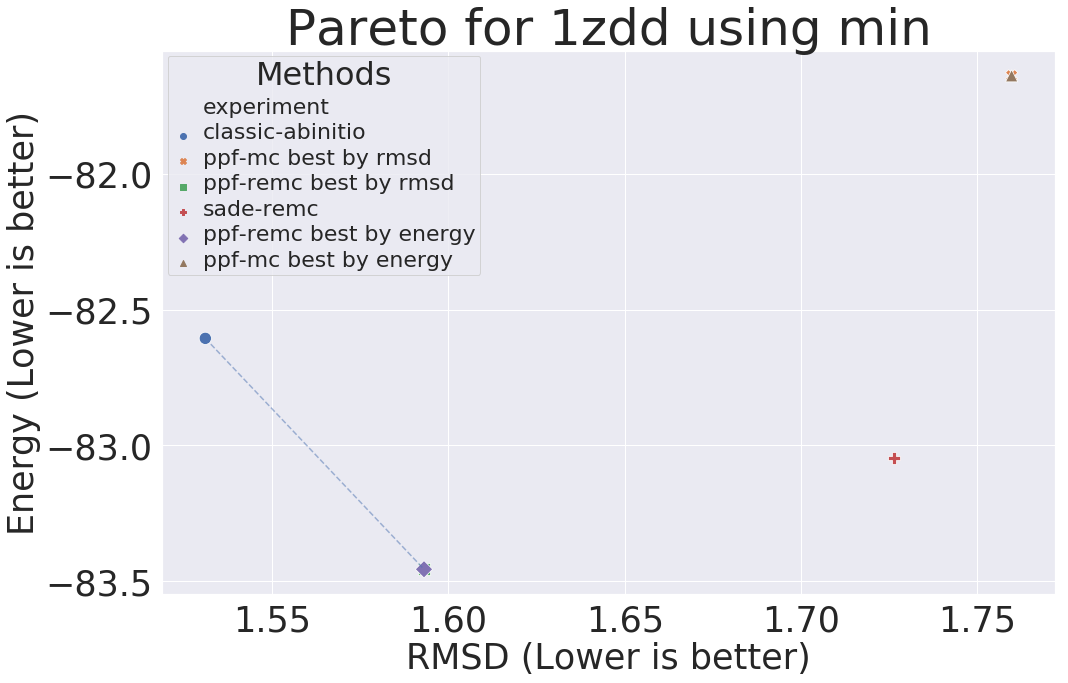

In [12]:
pareto_duo('1zdd')